import stuff (a lot of stuff) & read in data

In [1]:
import pandas as pd
import numpy as np
import category_encoders as ce
import datetime as dt
pd.options.mode.chained_assignment = None
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
pd.options.display.max_rows = 1000
pd.options.display.max_columns= 1000
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

import scipy.stats as stats
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor,MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import seaborn as sns

/Users/Jesse/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv('../datasets/ks-projects-201801.csv')

In [3]:
df = data.copy()

# data cleaning / transforming

In [4]:
df['titleLength'] = df['name'].apply(lambda x: len(str(x)))

In [5]:
df.drop(columns=['category','backers','ID','name','pledged','usd pledged','goal'], inplace=True)

In [6]:
df['launched'] = pd.to_datetime(df['launched'])
df['deadline'] = pd.to_datetime(df['deadline'])
df = df[df['launched']>'2000-01-01']

In [7]:
df = df[(df['usd_goal_real']<20000) & (df['usd_goal_real']>1)]
df = df[(df['usd_pledged_real']<20000) & (df['usd_pledged_real']>1)]

df['logGoal'] = np.log(df['usd_goal_real'])
df.drop(columns=['usd_goal_real'], inplace=True)

In [8]:
df['launchMonth'] = df['launched'].dt.month
df['launchDay'] = df['launched'].dt.dayofweek
df['launchHour'] = df['launched'].dt.hour

In [9]:
df['duration'] = (df['deadline']-df['launched'])/dt.timedelta(minutes=1)
df.drop(columns=['deadline','launched'],inplace=True)

In [10]:
df = df[(df['state']=='successful') | (df['state']=='failed')]

In [11]:
list(df.state.unique())

['successful', 'failed']

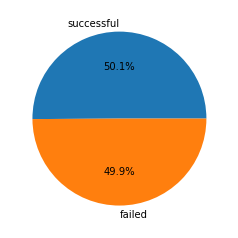

In [12]:
import matplotlib.pyplot as plt

slices = list(df.state.value_counts())
states = list(df.state.unique())
plt.pie(slices, labels=states,autopct='%.1f%%')
plt.show()

null accuracy: 50.1%

In [13]:
df['success'] = df['state'].apply(lambda x: 1 if x == "successful" else 0)
X = df.drop(columns=['state','success','usd_pledged_real'])
y = df['success']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [15]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).drop(['launchMonth','launchDay','launchHour'],axis=1).columns
categorical_features = list(X.select_dtypes(include=['object']).columns) + ['launchMonth','launchDay','launchHour']

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', ce.OneHotEncoder(), categorical_features)])

In [39]:
classifiers = [
        LogisticRegression(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        MLPClassifier()
    ]

for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
    pipe.fit(X_train, y_train)   
    print(classifier)
    print("model score: %.3f" % pipe.score(X_test, y_test))

/Users/Jesse/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
model score: 0.639
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
model score: 0.565


/Users/Jesse/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
model score: 0.602
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=F

In [40]:
from sklearn.model_selection import GridSearchCV

rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])


# each entry is structured like 'pipelineStepName__parameterName':[values to test]
param_grid = { 
    'classifier__max_depth' : [5,10,20],
    'classifier__min_samples_leaf': [10,50,100],
    'classifier__n_estimators':[10,20]
}

# pass in your pipeline & your parameter grid
CV = GridSearchCV(rf, param_grid, n_jobs=1,verbose=2)      
CV.fit(X, y)  
print(CV.best_params_)    
print(CV.best_score_)

/Users/Jesse/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] classifier__max_depth=5, classifier__min_samples_leaf=10, classifier__n_estimators=10 
[CV]  classifier__max_depth=5, classifier__min_samples_leaf=10, classifier__n_estimators=10, total=   3.0s
[CV] classifier__max_depth=5, classifier__min_samples_leaf=10, classifier__n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV]  classifier__max_depth=5, classifier__min_samples_leaf=10, classifier__n_estimators=10, total=   2.5s
[CV] classifier__max_depth=5, classifier__min_samples_leaf=10, classifier__n_estimators=10 
[CV]  classifier__max_depth=5, classifier__min_samples_leaf=10, classifier__n_estimators=10, total=   6.8s
[CV] classifier__max_depth=5, classifier__min_samples_leaf=10, classifier__n_estimators=20 
[CV]  classifier__max_depth=5, classifier__min_samples_leaf=10, classifier__n_estimators=20, total=   4.5s
[CV] classifier__max_depth=5, classifier__min_samples_leaf=10, classifier__n_estimators=20 
[CV]  classifier__max_depth=5, classifier__min_samples_leaf=10, classifier__n_estimators=20, total=   6.4s
[CV] classifier__max_depth=5, classifier__min_samples_leaf=10, classifier__n_estimators=20 
[CV]  classifier__max_depth=5, classifier__min_samples_leaf=10, classifier__n_estimators=20, total=   4.0s
[CV] classifier__max_depth=5, classifier__min_samples_leaf=50, classifier__n_estimators=10 
[CV] 

[CV]  classifier__max_depth=20, classifier__min_samples_leaf=50, classifier__n_estimators=10, total=   3.6s
[CV] classifier__max_depth=20, classifier__min_samples_leaf=50, classifier__n_estimators=10 
[CV]  classifier__max_depth=20, classifier__min_samples_leaf=50, classifier__n_estimators=10, total=   3.5s
[CV] classifier__max_depth=20, classifier__min_samples_leaf=50, classifier__n_estimators=10 
[CV]  classifier__max_depth=20, classifier__min_samples_leaf=50, classifier__n_estimators=10, total=   3.6s
[CV] classifier__max_depth=20, classifier__min_samples_leaf=50, classifier__n_estimators=20 
[CV]  classifier__max_depth=20, classifier__min_samples_leaf=50, classifier__n_estimators=20, total=   5.9s
[CV] classifier__max_depth=20, classifier__min_samples_leaf=50, classifier__n_estimators=20 
[CV]  classifier__max_depth=20, classifier__min_samples_leaf=50, classifier__n_estimators=20, total=   5.7s
[CV] classifier__max_depth=20, classifier__min_samples_leaf=50, classifier__n_estimators

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  4.1min finished


{'classifier__max_depth': 20, 'classifier__min_samples_leaf': 10, 'classifier__n_estimators': 20}
0.6455374188185646


In [41]:
from sklearn.model_selection import GridSearchCV

rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

param_grid =  {
    'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : [0.01, 0.1, 1],
    'classifier__solver' : ['liblinear','saga']
}
CV = GridSearchCV(rf, param_grid, n_jobs=1,verbose=2)
                  
CV.fit(X, y)  
print(CV.best_params_)    
print(CV.best_score_)

/Users/Jesse/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] classifier__C=0.01, classifier__penalty=l1, classifier__solver=liblinear 
[CV]  classifier__C=0.01, classifier__penalty=l1, classifier__solver=liblinear, total=   5.9s
[CV] classifier__C=0.01, classifier__penalty=l1, classifier__solver=liblinear 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s


[CV]  classifier__C=0.01, classifier__penalty=l1, classifier__solver=liblinear, total=   7.6s
[CV] classifier__C=0.01, classifier__penalty=l1, classifier__solver=liblinear 
[CV]  classifier__C=0.01, classifier__penalty=l1, classifier__solver=liblinear, total=   9.2s
[CV] classifier__C=0.01, classifier__penalty=l1, classifier__solver=saga 
[CV]  classifier__C=0.01, classifier__penalty=l1, classifier__solver=saga, total=   6.8s
[CV] classifier__C=0.01, classifier__penalty=l1, classifier__solver=saga 
[CV]  classifier__C=0.01, classifier__penalty=l1, classifier__solver=saga, total=   7.1s
[CV] classifier__C=0.01, classifier__penalty=l1, classifier__solver=saga 
[CV]  classifier__C=0.01, classifier__penalty=l1, classifier__solver=saga, total=  10.7s
[CV] classifier__C=0.01, classifier__penalty=l2, classifier__solver=liblinear 
[CV]  classifier__C=0.01, classifier__penalty=l2, classifier__solver=liblinear, total=   2.5s
[CV] classifier__C=0.01, classifier__penalty=l2, classifier__solver=lib

/Users/Jesse/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classifier__C=0.1, classifier__penalty=l1, classifier__solver=saga, total=  24.4s
[CV] classifier__C=0.1, classifier__penalty=l1, classifier__solver=saga 
[CV]  classifier__C=0.1, classifier__penalty=l1, classifier__solver=saga, total=  21.2s
[CV] classifier__C=0.1, classifier__penalty=l1, classifier__solver=saga 
[CV]  classifier__C=0.1, classifier__penalty=l1, classifier__solver=saga, total=  16.2s
[CV] classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear 
[CV]  classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, total=   2.6s
[CV] classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear 
[CV]  classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, total=   2.6s
[CV] classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear 
[CV]  classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, total=   2.6s
[CV] classifier__C=0.1, classifier__penalty=l2, classifier__solver=saga 


/Users/Jesse/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classifier__C=0.1, classifier__penalty=l2, classifier__solver=saga, total=  17.7s
[CV] classifier__C=0.1, classifier__penalty=l2, classifier__solver=saga 


/Users/Jesse/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classifier__C=0.1, classifier__penalty=l2, classifier__solver=saga, total=  17.9s
[CV] classifier__C=0.1, classifier__penalty=l2, classifier__solver=saga 


/Users/Jesse/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classifier__C=0.1, classifier__penalty=l2, classifier__solver=saga, total=  17.7s
[CV] classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear 
[CV]  classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, total=  23.8s
[CV] classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear 
[CV]  classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, total=  40.1s
[CV] classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear 
[CV]  classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, total=  30.8s
[CV] classifier__C=1, classifier__penalty=l1, classifier__solver=saga 


/Users/Jesse/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classifier__C=1, classifier__penalty=l1, classifier__solver=saga, total=  20.3s
[CV] classifier__C=1, classifier__penalty=l1, classifier__solver=saga 


/Users/Jesse/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classifier__C=1, classifier__penalty=l1, classifier__solver=saga, total=  20.0s
[CV] classifier__C=1, classifier__penalty=l1, classifier__solver=saga 


/Users/Jesse/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classifier__C=1, classifier__penalty=l1, classifier__solver=saga, total=  19.9s
[CV] classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear 
[CV]  classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, total=   3.1s
[CV] classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear 
[CV]  classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, total=   2.9s
[CV] classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear 
[CV]  classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, total=   3.2s
[CV] classifier__C=1, classifier__penalty=l2, classifier__solver=saga 


/Users/Jesse/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classifier__C=1, classifier__penalty=l2, classifier__solver=saga, total=  18.0s
[CV] classifier__C=1, classifier__penalty=l2, classifier__solver=saga 


/Users/Jesse/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classifier__C=1, classifier__penalty=l2, classifier__solver=saga, total=  18.1s
[CV] classifier__C=1, classifier__penalty=l2, classifier__solver=saga 


/Users/Jesse/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classifier__C=1, classifier__penalty=l2, classifier__solver=saga, total=  18.1s


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  7.5min finished


{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
0.6376910218584726


/Users/Jesse/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [43]:
classifiers = [
        MLPClassifier(hidden_layer_sizes=(25,), verbose=True),
        MLPClassifier(hidden_layer_sizes=(25,25,), verbose=True)
    ]

for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
    pipe.fit(X_train, y_train)   
    print(classifier)
    print("model score: %.3f" % pipe.score(X_test, y_test))

Iteration 1, loss = 0.65531937
Iteration 2, loss = 0.63776073
Iteration 3, loss = 0.63647727
Iteration 4, loss = 0.63579756
Iteration 5, loss = 0.63439660
Iteration 6, loss = 0.63379894
Iteration 7, loss = 0.63270565
Iteration 8, loss = 0.63224561
Iteration 9, loss = 0.63181099
Iteration 10, loss = 0.63131991
Iteration 11, loss = 0.63099618
Iteration 12, loss = 0.63059415
Iteration 13, loss = 0.63059045
Iteration 14, loss = 0.63028870
Iteration 15, loss = 0.62997543
Iteration 16, loss = 0.62990071
Iteration 17, loss = 0.62990199
Iteration 18, loss = 0.62957676
Iteration 19, loss = 0.62949392
Iteration 20, loss = 0.62926859
Iteration 21, loss = 0.62915647
Iteration 22, loss = 0.62904098
Iteration 23, loss = 0.62910644
Iteration 24, loss = 0.62880122
Iteration 25, loss = 0.62866621
Iteration 26, loss = 0.62863885
Iteration 27, loss = 0.62858261
Iteration 28, loss = 0.62840353
Iteration 29, loss = 0.62837508
Iteration 30, loss = 0.62842434
Iteration 31, loss = 0.62807241
Iteration 32, los

# testing geo/currency

In [23]:
X = df.drop(columns=['state','success','usd_pledged_real','currency'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [24]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).drop(['launchMonth','launchDay','launchHour'],axis=1).columns
categorical_features = list(X.select_dtypes(include=['object'])) + ['launchMonth','launchDay','launchHour']

from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', ce.OneHotEncoder(), categorical_features)])

In [25]:
classifier = RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=20)
pipe = Pipeline(steps=[('preprocessor', preprocessor),
              ('classifier', classifier)])
pipe.fit(X_train, y_train)   
print(classifier)
print("model score: %.3f" % pipe.score(X_test, y_test))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
model score: 0.651


# rf with ordinal encoding for feature importances

In [27]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).drop(['launchMonth','launchDay','launchHour'],axis=1).columns
categorical_features = list(X.select_dtypes(include=['object'])) + ['launchMonth','launchDay','launchHour']

from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', ce.OrdinalEncoder(), categorical_features)])

classifier = RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=20)

pipe = Pipeline(steps=[('preprocessor', preprocessor),
              ('classifier', classifier)])
pipe.fit(X_train, y_train)   
print(classifier)
print("model score: %.3f" % pipe.score(X_test, y_test))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
model score: 0.642


In [29]:
pd.DataFrame(zip(X.columns,classifier.feature_importances_),columns=['feature','importance']).sort_values(by='importance',ascending=False)

,feature,importance
1,country,0.246592
2,titleLength,0.233231
3,logGoal,0.163886
0,main_category,0.121046
7,duration,0.080262
5,launchDay,0.070510
6,launchHour,0.052810
4,launchMonth,0.031663


# model evaluation for rf

In [27]:
X.drop(columns=["currency"], inplace=True)
numeric_features = X.select_dtypes(include=['int64', 'float64']).drop(['launchMonth','launchDay','launchHour'],axis=1).columns
categorical_features = list(X.select_dtypes(include=['object'])) + ['launchMonth','launchDay','launchHour']

from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', ce.OrdinalEncoder(), categorical_features)])

classifier = RandomForestClassifier(max_depth=20, min_samples_leaf=50)

pipe = Pipeline(steps=[('preprocessor', preprocessor),
              ('classifier', classifier)])

pipe.fit(X, y)   
# y_pred = pipe.predict(X_test)

/Users/Jesse/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  Index(['titleLength', 'logGoal', 'duration'], dtype='object')),
                                                 ('cat',
                                                  OrdinalEncoder(cols=None,
                                                                 drop_invariant=False,
                                                                 handle_missing='value',
                                           

In [76]:
test = pd.DataFrame({"main_category":"Dance",
                     "country":"US",
                     "titleLength":len("join alex rudra for a night of 'banking and ballet'"),
                     "logGoal":np.log10(3000),
                     "launchMonth":10,
                     "launchDay":4.5,
                     "launchHour":15,
                     "duration":30*24*60
                    },index=[0])

pipe.predict(test)

array([1])

In [77]:
len("join alex rudra for a night of 'banking and ballet'")

51

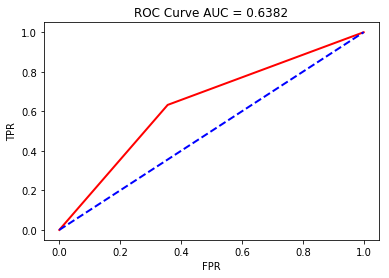

In [31]:
aucscore = metrics.roc_auc_score(y_pred, y_test)

fpr, tpr,_=roc_curve(y_pred, y_test)

plt.plot(fpr, tpr, color='red',lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve AUC = '+ str(aucscore.round(4)))
plt.show()

[Text(33.0, 0.5, 'Actual Class'),
 Text(0.5, 33.0, 'Predicted Class'),
 Text(0.5, 1.0, 'Confusion Matrix')]

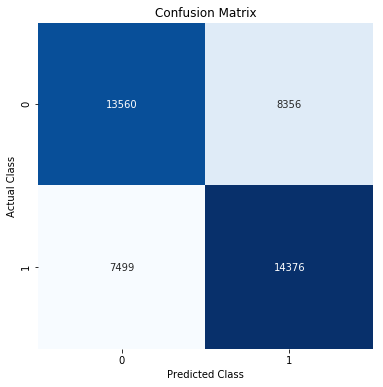

In [32]:
test_cf = pd.DataFrame(confusion_matrix(y_test,y_pred))

fig, ax = plt.subplots(figsize=(6,6))
ax = sns.heatmap(test_cf,annot=True,fmt='d',cmap='Blues',cbar=False)
ax.set(xlabel='Predicted Class',ylabel='Actual Class',title='Confusion Matrix')

[Text(33.0, 0.5, 'Actual Class'),
 Text(0.5, 33.0, 'Predicted Class'),
 Text(0.5, 1.0, 'Normalized Confusion Matrix')]

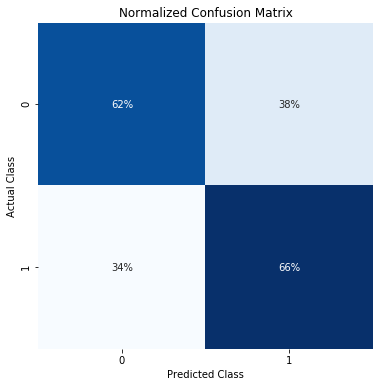

In [33]:
#returns an array of the number of samples per quadrant
test_cf = confusion_matrix(y_test,y_pred)

#for each row, divides the values by the row sum
test_cf = test_cf.astype('float') / test_cf.sum(axis=1)[:, np.newaxis]
test_cf = pd.DataFrame(test_cf)
                           
#create visualization
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.heatmap(test_cf,annot=True,cmap='Blues',cbar=False,fmt='.0%')
ax.set(xlabel='Predicted Class',ylabel='Actual Class',title='Normalized Confusion Matrix')

# model evaluation for mlp

In [34]:
classifier = MLPClassifier(hidden_layer_sizes=(25,), verbose=True)
pipe = Pipeline(steps=[('preprocessor', preprocessor),
              ('classifier', classifier)])
pipe.fit(X_train, y_train)   
y_pred = pipe.predict(X_test)

Iteration 1, loss = 0.72608335
Iteration 2, loss = 0.66090858
Iteration 3, loss = 0.65895872
Iteration 4, loss = 0.65766522
Iteration 5, loss = 0.65647041
Iteration 6, loss = 0.65460305
Iteration 7, loss = 0.65384601
Iteration 8, loss = 0.65334033
Iteration 9, loss = 0.65300830
Iteration 10, loss = 0.65292798
Iteration 11, loss = 0.65247193
Iteration 12, loss = 0.65215008
Iteration 13, loss = 0.65222667
Iteration 14, loss = 0.65208521
Iteration 15, loss = 0.65185674
Iteration 16, loss = 0.65181496
Iteration 17, loss = 0.65159031
Iteration 18, loss = 0.65182351
Iteration 19, loss = 0.65124541
Iteration 20, loss = 0.65105647
Iteration 21, loss = 0.65065472
Iteration 22, loss = 0.65075334
Iteration 23, loss = 0.65080663
Iteration 24, loss = 0.65050352
Iteration 25, loss = 0.65049194
Iteration 26, loss = 0.65015912
Iteration 27, loss = 0.65014219
Iteration 28, loss = 0.65002215
Iteration 29, loss = 0.64998207
Iteration 30, loss = 0.64965913
Iteration 31, loss = 0.64950904
Iteration 32, los

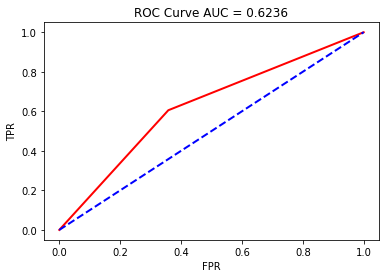

In [35]:
aucscore = metrics.roc_auc_score(y_pred, y_test)

fpr, tpr,_=roc_curve(y_pred, y_test)

plt.plot(fpr, tpr, color='red',lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve AUC = '+ str(aucscore.round(4)))
plt.show()

[Text(33.0, 0.5, 'Actual Class'),
 Text(0.5, 33.0, 'Predicted Class'),
 Text(0.5, 1.0, 'Confusion Matrix')]

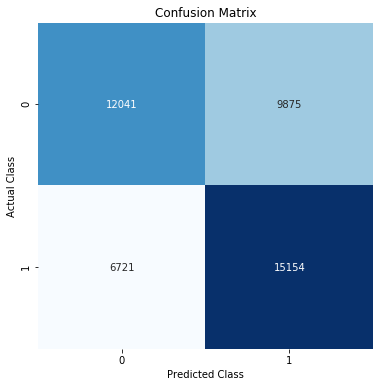

In [36]:
test_cf = pd.DataFrame(confusion_matrix(y_test,y_pred))

fig, ax = plt.subplots(figsize=(6,6))
ax = sns.heatmap(test_cf,annot=True,fmt='d',cmap='Blues',cbar=False)
ax.set(xlabel='Predicted Class',ylabel='Actual Class',title='Confusion Matrix')

[Text(33.0, 0.5, 'Actual Class'),
 Text(0.5, 33.0, 'Predicted Class'),
 Text(0.5, 1.0, 'Normalized Confusion Matrix')]

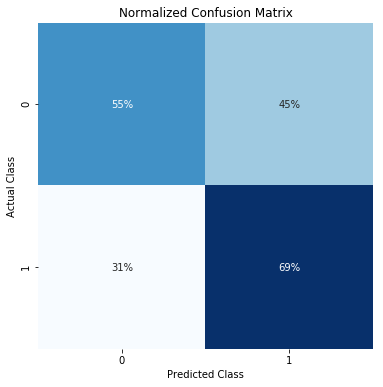

In [37]:
#returns an array of the number of samples per quadrant
test_cf = confusion_matrix(y_test,y_pred)

#for each row, divides the values by the row sum
test_cf = test_cf.astype('float') / test_cf.sum(axis=1)[:, np.newaxis]
test_cf = pd.DataFrame(test_cf)
                           
#create visualization
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.heatmap(test_cf,annot=True,cmap='Blues',cbar=False,fmt='.0%')
ax.set(xlabel='Predicted Class',ylabel='Actual Class',title='Normalized Confusion Matrix')

In [79]:
corr = np.corrcoef(X.T)
#must take transpose to get column-wise correlations
#visualize correlation matrix with a heatmap

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [ ]:
corr

In [ ]:
sns.heatmap(corr,vmin=-1,vmax=1)